#  Superviser Multi-Ai Agent

In [1]:
from typing import TypedDict, Annotated, List, Literal, Dict, Any
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage
from langgraph.graph import StateGraph, END, MessagesState
from langgraph.checkpoint.memory import MemorySaver
import random
from datetime import datetime
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
# ===================================
# State Definition
# ===================================

# ===================================
# State Definition
# ===================================

class SupervisorState(MessagesState):
    """State for the multi-agent system"""
    next_agent: str = ""
    research_data: str = ""
    analysis: str = ""
    final_report: str = ""
    task_complete: bool = False
    current_task: str = ""

In [3]:
from  langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature=0)

In [4]:
# ===================================
# Supervisor with Groq LLM
# ===================================
from langchain_core.prompts import ChatPromptTemplate
def create_supervisor_chain():
    """Creates the supervisor decision chain"""
    
    supervisor_prompt = ChatPromptTemplate.from_messages([
        ("system", """You are a supervisor managing a team of agents:
        
1. Researcher - Gathers information and data
2. Analyst - Analyzes data and provides insights  
3. Writer - Creates reports and summaries

Based on the current state and conversation, decide which agent should work next.
If the task is complete, respond with 'DONE'.

Current state:
- Has research data: {has_research}
- Has analysis: {has_analysis}
- Has report: {has_report}

Respond with ONLY the agent name (researcher/analyst/writer) or 'DONE'.
"""),
        ("human", "{task}")
    ])
    
    return supervisor_prompt | llm

In [5]:
def supervisor_agent(state: SupervisorState) -> Dict:
    """Supervisor decides next agent using Groq LLM"""
    
    messages = state["messages"]
    task = messages[-1].content if messages else "No task"
    
    # Check what's been completed
    has_research = bool(state.get("research_data", ""))
    has_analysis = bool(state.get("analysis", ""))
    has_report = bool(state.get("final_report", ""))
    
    # Get LLM decision
    chain = create_supervisor_chain()
    decision = chain.invoke({
        "task": task,
        "has_research": has_research,
        "has_analysis": has_analysis,
        "has_report": has_report
    })
    
    # Parse decision
    decision_text = decision.content.strip().lower()
    print(decision_text)
    
    # Determine next agent
    if "done" in decision_text or has_report:
        next_agent = "end"
        supervisor_msg = "✅ Supervisor: All tasks complete! Great work team."
    elif "researcher" in decision_text or not has_research:
        next_agent = "researcher"
        supervisor_msg = "📋 Supervisor: Let's start with research. Assigning to Researcher..."
    elif "analyst" in decision_text or (has_research and not has_analysis):
        next_agent = "analyst"
        supervisor_msg = "📋 Supervisor: Research done. Time for analysis. Assigning to Analyst..."
    elif "writer" in decision_text or (has_analysis and not has_report):
        next_agent = "writer"
        supervisor_msg = "📋 Supervisor: Analysis complete. Let's create the report. Assigning to Writer..."
    else:
        next_agent = "end"
        supervisor_msg = "✅ Supervisor: Task seems complete."
    
    return {
        "messages": [AIMessage(content=supervisor_msg)],
        "next_agent": next_agent,
        "current_task": task
    }

In [6]:
# ===================================
# Agent 1: Researcher (using Groq)
# ===================================

def researcher_agent(state: SupervisorState) -> Dict:
    """Researcher uses Groq to gather information"""
    
    task = state.get("current_task", "research topic")
    
    # Create research prompt
    research_prompt = f"""As a research specialist, provide comprehensive information about: {task}

    Include:
    1. Key facts and background
    2. Current trends or developments
    3. Important statistics or data points
    4. Notable examples or case studies
    
    Be concise but thorough."""
    
    # Get research from LLM
    research_response = llm.invoke([HumanMessage(content=research_prompt)])
    research_data = research_response.content
    
    # Create agent message
    agent_message = f"🔍 Researcher: I've completed the research on '{task}'.\n\nKey findings:\n{research_data[:500]}..."
    
    return {
        "messages": [AIMessage(content=agent_message)],
        "research_data": research_data,
        "next_agent": "supervisor"
    }

In [7]:
# ===================================
# Agent 2: Analyst (using Groq)
# ===================================

def analyst_agent(state: SupervisorState) -> Dict:
    """Analyst uses Groq to analyze the research"""
    
    research_data = state.get("research_data", "")
    task = state.get("current_task", "")
    
    # Create analysis prompt
    analysis_prompt = f"""As a data analyst, analyze this research data and provide insights:

Research Data:
{research_data}

Provide:
1. Key insights and patterns
2. Strategic implications
3. Risks and opportunities
4. Recommendations

Focus on actionable insights related to: {task}"""
    
    # Get analysis from LLM
    analysis_response = llm.invoke([HumanMessage(content=analysis_prompt)])
    analysis = analysis_response.content
    
    # Create agent message
    agent_message = f"📊 Analyst: I've completed the analysis.\n\nTop insights:\n{analysis[:400]}..."
    
    return {
        "messages": [AIMessage(content=agent_message)],
        "analysis": analysis,
        "next_agent": "supervisor"
    }

In [8]:
# ===================================
# Agent 3: Writer (using Groq)
# ===================================

def writer_agent(state: SupervisorState) -> Dict:
    """Writer uses Groq to create final report"""
    
    research_data = state.get("research_data", "")
    analysis = state.get("analysis", "")
    task = state.get("current_task", "")
    
    # Create writing prompt
    writing_prompt = f"""As a professional writer, create an executive report based on:

Task: {task}

Research Findings:
{research_data[:1000]}

Analysis:
{analysis[:1000]}

Create a well-structured report with:
1. Executive Summary
2. Key Findings  
3. Analysis & Insights
4. Recommendations
5. Conclusion

Keep it professional and concise."""
    
    # Get report from LLM
    report_response = llm.invoke([HumanMessage(content=writing_prompt)])
    report = report_response.content
    
    # Create final formatted report
    final_report = f"""
📄 FINAL REPORT
{'='*50}
Generated: {datetime.now().strftime('%Y-%m-%d %H:%M')}
Topic: {task}
{'='*50}

{report}

{'='*50}
Report compiled by Multi-Agent AI System powered by Groq
"""
    
    return {
        "messages": [AIMessage(content=f"✍️ Writer: Report complete! See below for the full document.")],
        "final_report": final_report,
        "next_agent": "supervisor",
        "task_complete": True
    }

In [9]:
# ===================================
# Router Function
# ===================================

def router(state: SupervisorState) -> Literal["supervisor", "researcher", "analyst", "writer", "__end__"]:
    """Routes to next agent based on state"""
    
    next_agent = state.get("next_agent", "supervisor")
    
    if next_agent == "end" or state.get("task_complete", False):
        return END
        
    if next_agent in ["supervisor", "researcher", "analyst", "writer"]:
        return next_agent
        
    return "supervisor"

In [10]:
# Create workflow
workflow = StateGraph(SupervisorState)

# Add nodes
workflow.add_node("supervisor", supervisor_agent)
workflow.add_node("researcher", researcher_agent)
workflow.add_node("analyst", analyst_agent)
workflow.add_node("writer", writer_agent)

# Set entry point
workflow.set_entry_point("supervisor")

# Add routing
for node in ["supervisor", "researcher", "analyst", "writer"]:
    workflow.add_conditional_edges(
        node,
        router,
        {
            "supervisor": "supervisor",
            "researcher": "researcher",
            "analyst": "analyst",
            "writer": "writer",
            END: END
        }
    )

graph=workflow.compile()
    

In [11]:
response=graph.invoke(HumanMessage(content="What are the benefits and risks of AI in healthcare?"))

done


In [13]:
response

{'messages': [AIMessage(content='✅ Supervisor: All tasks complete! Great work team.', additional_kwargs={}, response_metadata={}, id='ee1e4bec-d4d5-45d3-a20a-5eb413615244', tool_calls=[], invalid_tool_calls=[])],
 'next_agent': 'end',
 'current_task': 'No task'}

# Data Analysis Agent



In [39]:
from typing import TypedDict, Literal
from langgraph.graph import StateGraph, END
from langchain_ollama import OllamaLLM


In [ ]:
class DataState(TypedDict):
    question: str
    csv_path: str
    csv_data: dict
    analysis_result: str
    final_answer: str
    next: str



In [41]:
# Tools
import pandas as pd

def load_csv_tool(file_path: str) -> dict:
    df = pd.read_csv(file_path)

    return {
        "columns": list(df.columns),
        "rows": len(df),
        "head": df.head(5).to_dict(),
        "describe": df.describe(include="all").to_dict()
    }


In [42]:
llm = OllamaLLM(
    model="deepseek-r1:latest",    
    temperature=0
)

In [43]:
# Supervisor

def supervisor(state: DataState) -> DataState:
    if not state.get("csv_data"):
        state["next"] = "csv_loader_agent"

    elif not state.get("analysis_result"):
        state["next"] = "analysis_agent"

    elif not state.get("final_answer"):
        state["next"] = "report_agent"

    else:
        state["next"] = "END"

    return state


In [44]:
# Tool Agent
def csv_loader_agent(state: DataState) -> DataState:
    csv_path = state["csv_path"]

    csv_data = load_csv_tool(csv_path)

    state["csv_data"] = csv_data
    return state


In [45]:
# ANALYSIS AGENT
def analysis_agent(state: DataState) -> DataState:
    prompt = f"""
You are a data analyst.

Dataset details:
Columns: {state['csv_data']['columns']}
Rows: {state['csv_data']['rows']}
Summary stats:
{state['csv_data']['describe']}

Question:
{state['question']}

Provide insights.
"""
    state["analysis_result"] = llm.invoke(prompt)
    return state

# REPORT AGENT
def report_agent(state: DataState) -> DataState:
    prompt = f"""
Write a clear, structured final report using these insights:
{state['analysis_result']}
"""
    state["final_answer"] = llm.invoke(prompt)
    return state


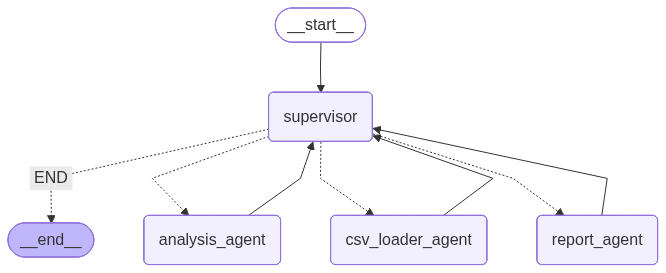

In [46]:
from langgraph.graph import StateGraph, END

graph = StateGraph(DataState)

graph.add_node("supervisor", supervisor)
graph.add_node("csv_loader_agent", csv_loader_agent)
graph.add_node("analysis_agent", analysis_agent)
graph.add_node("report_agent", report_agent)

graph.set_entry_point("supervisor")

graph.add_conditional_edges(
    "supervisor",
    lambda state: state["next"],
    {
        "csv_loader_agent": "csv_loader_agent",
        "analysis_agent": "analysis_agent",
        "report_agent": "report_agent",
        "END": END
    }
)

graph.add_edge("csv_loader_agent", "supervisor")
graph.add_edge("analysis_agent", "supervisor")
graph.add_edge("report_agent", "supervisor")

app = graph.compile()
app

In [47]:
initial_state = {
    "question": "Analyze monthly sales and profit trends",
    "csv_path": "sales.csv",
    "csv_data": {},
    "analysis_result": "",
    "final_answer": "",
    "next": ""
}

result = app.invoke(initial_state)

print(result["final_answer"])


Okay, here is a structured final report based on the insights provided.

---

**Final Report: Analysis of Sales and Profit Trends**

**Date:** October 26, 2023
**Prepared For:** Stakeholders
**Prepared By:** Data Analysis Team

**Executive Summary**

This report analyzes the provided dataset focusing on monthly sales and profit trends. Key findings indicate moderate monthly sales and profit figures, with sales showing higher variability than profits. However, a critical limitation hinders robust trend analysis: the 'monthly' column contains only 'January' entries, making it impossible to track trends across different months within a year. Recommendations focus on clarifying the 'monthly' column's meaning, increasing data volume, and verifying product data to enable more meaningful analysis in the future.

**1. Introduction**

This report aims to analyze the monthly sales and profit performance based on the provided dataset summary. The primary objectives were to identify trends in sale

**Final Report: Analysis of Sales and Profit Trends**

**Date:** October 26, 2023
**Prepared For:** Stakeholders
**Prepared By:** Data Analysis Team

**Executive Summary**

This report analyzes the provided dataset focusing on monthly sales and profit trends. Key findings indicate moderate monthly sales and profit figures, with sales showing higher variability than profits. However, a critical limitation hinders robust trend analysis: the 'monthly' column contains only 'January' entries, making it impossible to track trends across different months within a year. Recommendations focus on clarifying the 'monthly' column's meaning, increasing data volume, and verifying product data to enable more meaningful analysis in the future.

**1. Introduction**

This report aims to analyze the monthly sales and profit performance based on the provided dataset summary. The primary objectives were to identify trends in sales and profits over time and to assess the overall performance characteristics. The analysis is constrained by the specific data structure observed in the summary.

**2. Data Analysis**

The analysis is based on the summary statistics provided for the 'Sales', 'Monthly', 'Product Name', and 'Profit' columns.

*   **Sales Performance:**
    *   The average monthly sale is $1,630.
    *   Sales range from a minimum of $1,100 to a maximum of $2,100.
    *   The standard deviation of $333 indicates moderate variability in monthly sales figures.

*   **Monthly Trend (Limitations):**
    *   The 'Monthly' column presents a significant issue. It contains 10 unique entries, all identical: 'January'. This is highly unusual for analyzing monthly trends.
    *   Possible interpretations:
        *   The dataset only contains data for January across multiple years (e.g., 10 years of January data).
        *   There is a data entry error, and the 'monthly' column should reflect different months.
        *   'Monthly' is incorrectly coded as a categorical variable representing something other than months (e.g., product categories, regions).
    *   **Conclusion:** Due to the uniform 'January' value, it is impossible to determine if there is a seasonal or monthly trend in sales. The data does not represent distinct months within a year.

*   **Product Focus:**
    *   The 'Product Name' column shows all entries are 'Laptop' (frequency 1).
    *   **Conclusion:** The dataset appears to exclusively contain data for laptop sales. While this narrows the scope, it also limits the ability to analyze performance across different product lines. This could be intentional (focusing solely on laptops) or indicative of a data limitation (all entries should be 'Laptop').

*   **Profit Performance:**
    *   The average monthly profit is $387.
    *   Profit ranges from a minimum of $200 to a maximum of $550.
    *   The standard deviation of $120 indicates lower variability in monthly profits compared to sales.

*   **Profit Trend (Limitations):**
    *   Like the sales trend, the inability to properly interpret the 'monthly' column prevents any analysis of profit trends over time within a year.
    *   **Conclusion:** Without distinct monthly data, no conclusion can be drawn regarding monthly profit trends. However, within the available data (assuming distinct months), profits appear relatively stable, averaging $387 with a narrower range ($200-$550) compared to sales ($1100-$2100).

**3. Key Insights**

Based on the analysis, the following key insights emerge:

1.  **Moderate Sales and Profit:** Average monthly sales ($1,630) and profits ($387) are moderate figures.
2.  **Higher Sales Volatility:** Sales figures show more variability than profits, suggesting potential fluctuations in revenue streams or costs impacting sales directly.
3.  **Critical Data Limitation ('Monthly' Column):** The most significant barrier to analysis is the 'monthly' column. Its uniform 'January' value prevents any meaningful time-series trend analysis (monthly or seasonal).
4.  **Narrow Product Scope:** The data is focused exclusively on laptop sales, limiting cross-product analysis.
5.  **Stable Profitability (Within Data Constraints):** Assuming the 'monthly' column accurately reflects distinct months, the data suggests relatively stable monthly profitability. However, this finding is critically dependent on resolving the 'monthly' column issue.

**4. Recommendations**

To enhance future analysis and address the current limitations, the following recommendations are proposed:

1.  **Clarify the 'Monthly' Column:**
    *   Urgently investigate the purpose and content of the 'monthly' column. Determine if it truly represents calendar months (Jan-Dec) across multiple years, or if it represents something else (e.g., product categories, regions, data points).
    *   Standardize the column to contain valid month names (Jan-Dec) if it is intended for time-based analysis. Clean any erroneous entries.
2.  **Increase Data Size and Diversity:**
    *   Collect data covering multiple distinct months within a year to enable trend analysis.
    *   Gather data over a longer period (multiple years) to improve the robustness of any identified trends.
3.  **Verify Product Data:**
    *   Confirm the accuracy of the 'Product Name' column. Determine if the dataset is intentionally focused solely on laptops or if it suffers from a data limitation where other products should be included.
4.  **Future Analysis Strategy:**
    *   Once the 'monthly' column is resolved and the dataset expanded, revisit the sales and profit trend analysis to identify patterns, seasonality, and opportunities for improvement.

**5. Conclusion**

The provided dataset offers baseline figures for monthly sales and profits but is fundamentally limited in its ability to analyze temporal trends due to the problematic 'monthly' column. While laptops appear to be consistently profitable (averaging $387 profit per month), the lack of reliable monthly data prevents deeper insights into performance fluctuations or seasonality. Immediate action is required to clarify the 'monthly' column and expand the dataset to unlock the full potential for meaningful business insights and informed decision-making.
